# CCPP Classification-Regression

https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.



In [1]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report


In [4]:
# read .csv from provided dataset
csv_filename="CCPP/Folds5x2_pp.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

In [5]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [9]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [11]:
# handle PE attrubte to binary
high = df.PE >= 450
low = df.PE < 450
df.loc[high,'PE'] = 1
df.loc[low,'PE'] = 0

In [12]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,1.0
1,23.64,58.49,1011.40,74.20,0.0
2,29.74,56.90,1007.15,41.91,0.0
3,19.07,49.69,1007.22,76.79,1.0
4,11.80,40.66,1017.13,97.20,1.0


In [13]:
features=list(df.columns[:-1])

In [15]:
X = df[features]
y = df['PE']

In [16]:
# split dataset to 60% training and 40% testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.4, random_state=0)

In [17]:
print X_train.shape, y_train.shape

(5740, 4) (5740L,)


### Feature importances with forests of trees

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X = df[features]
y = df['shares']
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f) " % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [102]:
importances[indices[:5]]

array([ 0.03030539,  0.02698445,  0.0269827 ,  0.02358878,  0.02318772])

In [88]:
for f in range(5):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 39 LDA_02 (0.030305)
2. feature 25 kw_avg_avg (0.026984)
3. feature 23 kw_min_avg (0.026983)
4. feature 38 LDA_01 (0.023589)
5. feature 37 LDA_00 (0.023188)


In [141]:
best_features = []
for i in indices[:5]:
    best_features.append(features[i])

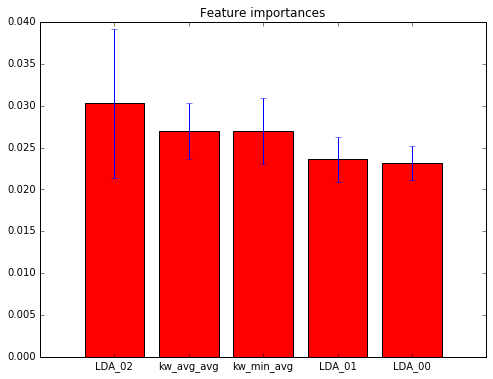

In [143]:
# Plot the top 5 feature importances of the forest
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5], 
       color="r",  yerr=std[indices][:5], align="center")
plt.xticks(range(5), best_features)
plt.xlim([-1, 5])
plt.show()

# Decision Tree accuracy and time elapsed caculation

In [18]:
t0=time()
print "DecisionTree"

dt = DecisionTreeClassifier(min_samples_split=20,random_state=99)
# dt = DecisionTreeClassifier(min_samples_split=20,max_depth=5,random_state=99)

clf_dt=dt.fit(X_train,y_train)

print "Acurracy: ", clf_dt.score(X_test,y_test)
t1=time()
print "time elapsed: ", t1-t0

DecisionTree
Acurracy:  0.948275862069
time elapsed:  0.074000120163


## cross validation for DT

In [20]:
tt0=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, X,y, cv=5)
print scores
print scores.mean()
tt1=time()
print "time elapsed: ", tt1-tt0
print "\n"

cross result========
[ 0.9477534   0.94827586  0.94566353  0.94354417  0.94668061]
0.946383513561
time elapsed:  0.475000143051




In [ ]:
### Tuning our hyperparameters using GridSearch

In [146]:
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(criterion='entropy'))
])

parameters = {
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)

print classification_report(y_test, predictions)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.5min finished


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best score: 0.662
Best parameters set:
	clf__max_depth: 5
	clf__min_samples_leaf: 5
	clf__min_samples_split: 1
             precision    recall  f1-score   support

          0       0.62      0.59      0.60      7427
          1       0.65      0.68      0.67      8431

avg / total       0.64      0.64      0.64     15858



# Random Forest accuracy and time elapsed caculation

In [21]:
t2=time()
print "RandomForest"
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rf = rf.fit(X_train,y_train)
print "Acurracy: ", clf_rf.score(X_test,y_test)
t3=time()
print "time elapsed: ", t3-t2

RandomForest
Acurracy:  0.963166144201
time elapsed:  1.14999985695


## cross validation for RF

In [23]:
tt2=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, X,y, cv=5)
print scores
print scores.mean()
tt3=time()
print "time elapsed: ", tt3-tt2
print "\n"


cross result========
[ 0.9477534   0.94827586  0.94566353  0.94354417  0.94668061]
0.946383513561
time elapsed:  0.457999944687




### Receiver Operating Characteristic (ROC) curve

In [24]:
roc_auc_score(y_test,rf.predict(X_test))

0.96350269429597823

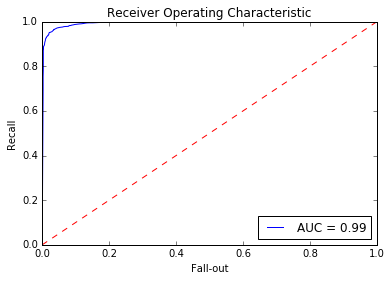

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

predictions = rf.predict_proba(X_test)

false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

### Tuning Models using GridSearch

In [26]:

pipeline2 = Pipeline([
('clf', RandomForestClassifier(criterion='entropy'))
])

parameters = {
    'clf__n_estimators': (5, 25, 50, 100),
    'clf__max_depth': (5, 25 , 50),
    'clf__min_samples_split': (1, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3)
}

grid_search = GridSearchCV(pipeline2, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=3)

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
print 'Accuracy:', accuracy_score(y_test, predictions)
print classification_report(y_test, predictions)
    

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  5.9min finished


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best score: 0.960
Best parameters set:
	clf__max_depth: 50
	clf__min_samples_leaf: 1
	clf__min_samples_split: 1
	clf__n_estimators: 100
Accuracy: 0.966300940439
             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96      1808
        1.0       0.97      0.96      0.97      2020

avg / total       0.97      0.97      0.97      3828



# Naive Bayes accuracy and time elapsed caculation


In [30]:
t4=time()
print "NaiveBayes"
nb = BernoulliNB()
clf_nb=nb.fit(X_train,y_train)
print "Acurracy: ", clf_nb.score(X_test,y_test)
t5=time()
print "time elapsed: ", t5-t4

NaiveBayes
Acurracy:  0.527690700104
time elapsed:  0.0369999408722


## cross-validation for NB

In [31]:
tt4=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, X,y, cv=5)
print scores
print scores.mean()
tt5=time()
print "time elapsed: ", tt5-tt4
print "\n"

cross result========
[ 0.9477534   0.94827586  0.94566353  0.94354417  0.94668061]
0.946383513561
time elapsed:  0.378999948502




# KNN accuracy and time elapsed caculation

In [32]:
t6=time()
print "KNN"
# knn = KNeighborsClassifier(n_neighbors=3)
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, y_train)
print "Acurracy: ", clf_knn.score(X_test,y_test) 
t7=time()
print "time elapsed: ", t7-t6

KNN
Acurracy:  0.949843260188
time elapsed:  0.131999969482


## cross validation for KNN

In [34]:
tt6=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, X,y, cv=5)
print scores
print scores.mean()
tt7=time()
print "time elapsed: ", tt7-tt6
print "\n"

cross result========
[ 0.9477534   0.94827586  0.94566353  0.94354417  0.94668061]
0.946383513561
time elapsed:  0.378000020981




# SVM accuracy and time elapsed caculation

In [35]:
t7=time()
print "SVM"

svc = SVC()
clf_svc=svc.fit(X_train, y_train)
print "Acurracy: ", clf_svc.score(X_test,y_test) 
t8=time()
print "time elapsed: ", t8-t7

SVM
Acurracy:  0.950365726228
time elapsed:  10.7409999371


## cross validation for SVM

In [37]:
tt7=time()
print "cross result========"
scores = cross_validation.cross_val_score(dt, X,y, cv=5)
print scores
print scores.mean()
tt8=time()
print "time elapsed: ", tt7-tt6
print "\n"

cross result========
[ 0.9477534   0.94827586  0.94566353  0.94354417  0.94668061]
0.946383513561
time elapsed:  22.8220000267




In [ ]:
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import grid_search

svc = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid = grid_search.GridSearchCV(svc, parameters, n_jobs=-1, verbose=1, scoring='accuracy')


grid.fit(X_train, y_train)

print 'Best score: %0.3f' % grid.best_score_

print 'Best parameters set:'
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid.predict(X_test)
print classification_report(y_test, predictions)

In [ ]:
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
])

parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)
print classification_report(y_test, predictions)

___
# Regression

In [38]:
# read .csv from provided dataset
csv_filename="CCPP/Folds5x2_pp.csv"

# df=pd.read_csv(csv_filename,index_col=0)
df=pd.read_csv(csv_filename)

In [39]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [43]:
cols = df.columns

In [41]:
features=list(df.columns[:-1])

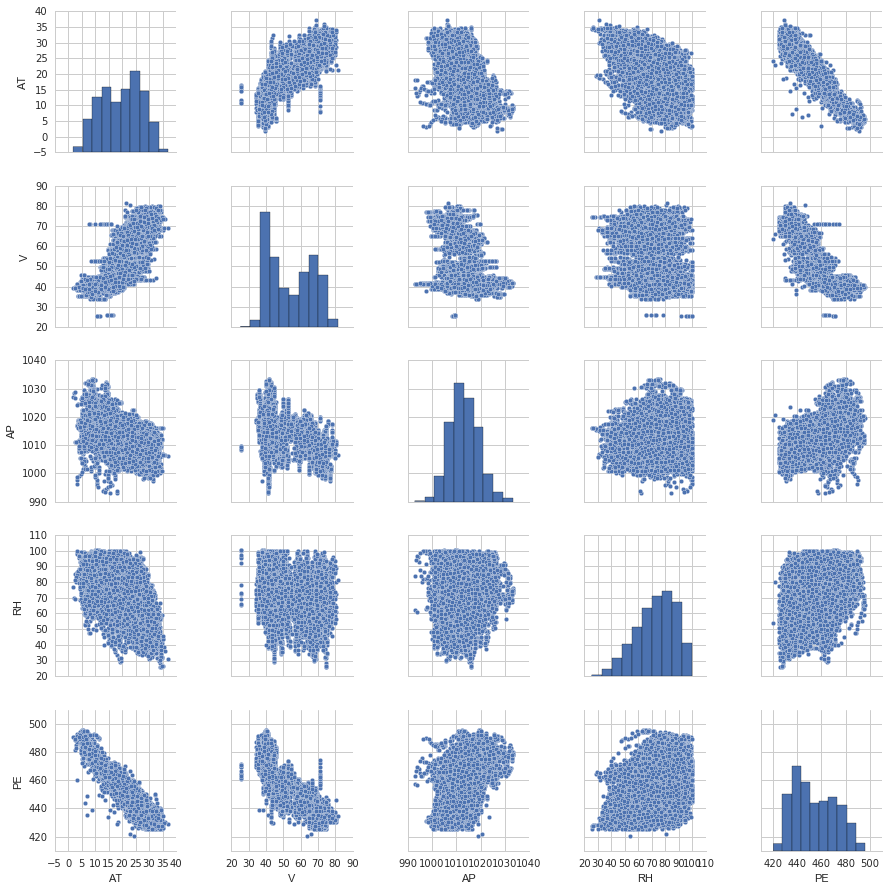

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

sns.pairplot(df, size=2.5);
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

As we can see in the following figure, the scatterplot matrix provides us with a
useful graphical summary of the relationships in a dataset.

Using this scatterplot matrix, we can now quickly eyeball how the data is distributed
and whether it contains outliers. For example, we can see that there is a negative linear
relationship between AT and the energy PE (the fifth column of the
first row) and a slight linear
relationship between AT and the V (the second column of the
first row). . 
To quantify the linear relationship between the features, we will now create a
correlation matrix.  Intuitively, we can interpret the correlation matrix as a rescaled version of the covariance matrix.
In fact, the correlation matrix is identical to a covariance matrix computed from
standardized data.

The correlation matrix is a square matrix that contains the Pearson product-moment
correlation coefficients (often abbreviated as Pearson's r), which measure the linear
dependence between pairs of features. The correlation coefficients are bounded
to the range -1 and 1. Two features have a perfect positive correlation if r =1, no
correlation if r = 0 , and a perfect negative correlation if r = −1, respectively.

In the following code example, we will use NumPy's corrcoef function on the five
feature columns that we previously visualized in the scatterplot matrix, and we will
use seaborn's heatmap function to plot the correlation matrix array as a heat map:

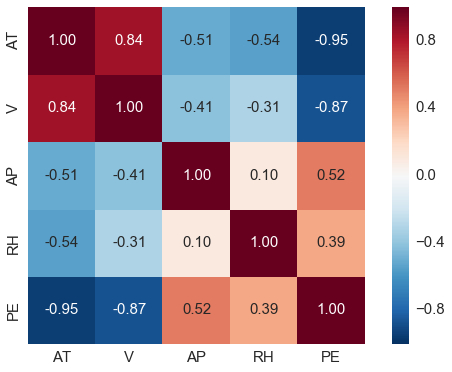

In [44]:
import numpy as np
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)

plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

As we can see in the resulting figure, the correlation matrix provides us with another
useful summary graphic that can help us to select features based on their respective
linear correlations.

To fit a linear regression model, we are interested in those features that have a high
correlation with our target variable MEDV. Looking at the preceding correlation
matrix, we see that our target variable PE shows the largest correlation with
the AT variable (-0.95). PE also shows a large correlation with
the V variable (-0.87). However, as you might remember from the scatterplot
matrix, there is a doubtful nonlinear relationship between V and PE. So
given the linear relationship between PE and AT that we observed in the
scatterplot, AT seems to be a good choice for an exploratory variable to introduce
the concepts of a simple linear regression model in the following section.

In [99]:
X = df[['AT']].values
y = df['PE'].values

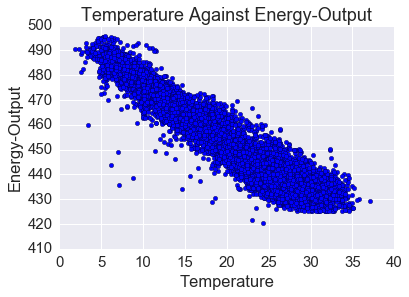

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df['AT'], df['PE'])
plt.xlabel('Temperature')
plt.ylabel('Energy-Output')
plt.title('Temperature Against Energy-Output')
plt.show()

In [47]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: -2.171
Intercept: 497.034


In [50]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

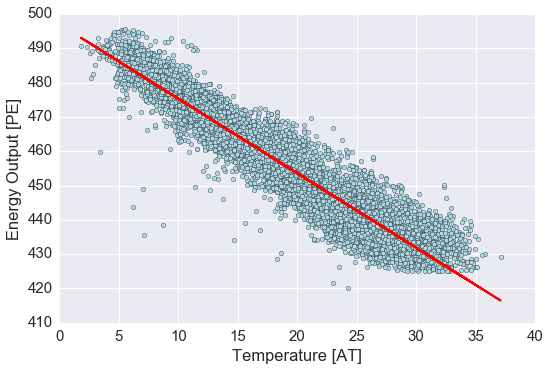

In [57]:
lin_regplot(X, y, slr)
plt.xlabel('Temperature [AT]')
plt.ylabel('Energy Output [PE]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

## Fitting a robust regression model using RANSAC

Linear regression models can be heavily impacted by the presence of outliers.
In certain situations, a very small subset of our data can have a big effect on the
estimated model coefficients. There are many statistical tests that can be used to
detect outliers, which are beyond the scope of the book. However, removing
outliers always requires our own judgment as a data scientist, as well as our
domain knowledge.

As an alternative to throwing out outliers, we will look at a robust method of
regression using the RANdom SAmple Consensus (RANSAC) algorithm,
which fits a regression model to a subset of the data, the so-called inliers.
We can summarize the iterative RANSAC algorithm as follows:

1. Select a random number of samples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached; go back to step 1 otherwise.

Let's now wrap our linear model in the RANSAC algorithm using scikit-learn's
RANSACRegressor object:

In [100]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                         residual_threshold=5.0, 
                         random_state=0)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

We set the maximum number of iterations of the RANSACRegressor to 100, and using
min_samples=50, we set the minimum number of the randomly chosen samples to
be at least 50. Using the residual_metric parameter, we provided a callable lambda
function that simply calculates the absolute vertical distances between the fitted line
and the sample points. By setting the residual_threshold parameter to 5.0, we
only allowed samples to be included in the inlier set if their vertical distance to the
fitted line is within 5 distance units, which works well on this particular dataset. By
default, scikit-learn uses the MAD estimate to select the inlier threshold, where MAD
stands for the Median Absolute Deviation of the target values y. However, the choice
of an appropriate value for the inlier threshold is problem-specific, which is one
disadvantage of RANSAC. 
After we have fitted the RANSAC model, let's obtain the inliers and outliers from the
fitted RANSAC linear regression model and plot them together with the linear fit:

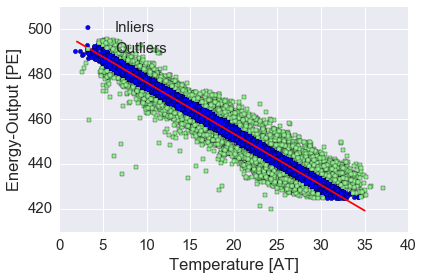

In [105]:
line_X = np.arange(2, 36, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Temperature [AT]')
plt.ylabel('Energy-Output [PE]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [62]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: -2.281
Intercept: 499.207


When we print the slope and intercept of the model executing the following code,
we can see that the linear regression line is slightly different from the fit that we
obtained in the previous section without RANSAC:

Using RANSAC, we reduced the potential effect of the outliers in this dataset,
but we don't know if this approach has a positive effect on the predictive
performance for unseen data. Thus, in the next section we will discuss how to
evaluate a regression model for different approaches, which is a crucial part of
building systems for predictive modeling.

## Evaluating the performance of linear regression models

In the previous section, we discussed how to fit a regression model on training data.
However, you learned in previous chapters that it is crucial to test the model on data
that it hasn't seen during training to obtain an unbiased estimate of its performance.

We want to split our dataset into separate training and
test datasets where we use the former to fit the model and the latter to evaluate its
performance to generalize to unseen data. Instead of proceeding with the simple
regression model, we will now use all variables in the dataset and train a multiple
regression model:

In [66]:
from sklearn.cross_validation import train_test_split

X = df[features].values
y = df['PE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [70]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Since our model uses multiple explanatory variables, we can't visualize the linear
regression line (or hyperplane to be precise) in a two-dimensional plot, but we
can plot the residuals (the differences or vertical distances between the actual and
predicted values) versus the predicted values to diagnose our regression model.
Those residual plots are a commonly used graphical analysis for diagnosing
regression models to detect nonlinearity and outliers, and to check if the errors
are randomly distributed.
Using the following code, we will now plot a residual plot where we simply subtract
the true target variables from our predicted responses:

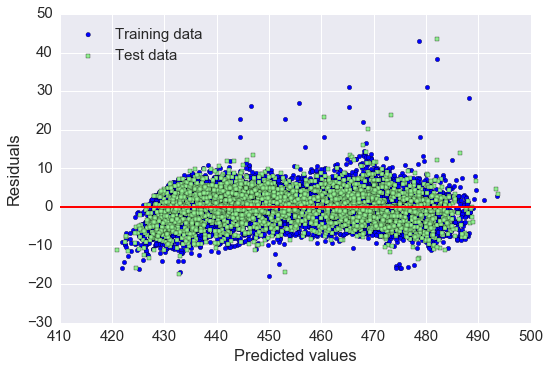

In [74]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=410, xmax=500, lw=2, color='red')
plt.xlim([410, 500])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

After executing the code, we should see a residual plot with a line passing through
the x axis origin as shown. 

In the case of a perfect prediction, the residuals would be exactly zero, which we will
probably never encounter in realistic and practical applications. However, for a good
regression model, we would expect that the errors are randomly distributed and
the residuals should be randomly scattered around the centerline. If we see patterns
in a residual plot, it means that our model is unable to capture some explanatory
information, which is leaked into the residuals as we can slightly see in our preceding
residual plot. Furthermore, we can also use residual plots to detect outliers, which are
represented by the points with a large deviation from the centerline.

Another useful quantitative measure of a model's performance is the so-called
Mean Squared Error (MSE), which is simply the average value of the SSE cost
function that we minimize to fit the linear regression model. The MSE is useful
to for comparing different regression models or for tuning their parameters via
a grid search and cross-validation.

In [75]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.841, test: 20.603
R^2 train: 0.929, test: 0.929


We will see that the MSE on the training set is 20.841, and the MSE of the test set is
lower with a value of 20.603.

Sometimes it may be more useful to report the coefficient of determination ( R2 ), which
can be understood as a standardized version of the MSE, for better interpretability of
the model performance. In other words, R2 is the fraction of response variance that is
captured by the model. The R2 value is defined as follows:
R^2 =  1 - (SSE / SST)

Here, SSE is the sum of squared errors and SST is the total sum of squares

For the training dataset, R^2 is bounded between 0 and 1, but it can become
negative for the test set. If R^2 =1, the model fits the data perfectly with a
corresponding MSE = 0 .

## Using regularized methods for regression

Regularization is one approach to tackle the problem of overfitting by
adding additional information, and thereby shrinking the parameter values of the
model to induce a penalty against complexity. The most popular approaches to
regularized linear regression are the so-called Ridge Regression, Least Absolute
Shrinkage and Selection Operator (LASSO) and Elastic Net method.

Ridge regression is an L2 penalized model where we simply add the squared sum of
the weights to our least-squares cost function.

By increasing the value of the hyperparameter lamda , we increase the regularization
strength and shrink the weights of our model. 
.
An alternative approach that can lead to sparse models is the LASSO. Depending
on the regularization strength, certain weights can become zero, which makes the
LASSO also useful as a supervised feature selection technique.

However, a limitation of the LASSO is that it selects at most n variables if m > n . A
compromise between Ridge regression and the LASSO is the Elastic Net, which has a
L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations
of the LASSO, such as the number of selected variables.

Those regularized regression models are all available via scikit-learn, and the
usage is similar to the regular regression model except that we have to specify the
regularization strength via the parameter  , for example, optimized via k-fold
cross-validation.

A Lasso Regression model can be initialized as follows:

In [77]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-1.97481786 -0.23462441  0.06665247 -0.1569416 ]


In [78]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.841, test: 20.599
R^2 train: 0.929, test: 0.929


Similiarly Ridge regression can be used:

In [79]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print(ridge.coef_)

[-1.97976314 -0.23301377  0.06813079 -0.15838948]


Lastly, the ElasticNet implementation allows us to vary the L1 to L2 ratio:

In [81]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=1.0, l1_ratio=0.5)
en.fit(X_train, y_train)
y_train_pred = en.predict(X_train)
y_test_pred = en.predict(X_test)
print(en.coef_)

[-1.85836784 -0.27739577  0.08487666 -0.1348257 ]


For example, if we set l1_ratio to 1.0, the ElasticNet regressor would be
equal to LASSO regression.

## Modeling nonlinear relationships in our dataset

By executing the following code, we will model the relationship between Energy Output PE and V (Exhaust Vacuum) using second degree (quadratic) and third degree (cubic) polynomials
and compare it to a linear fit.

In [83]:
from sklearn.preprocessing import PolynomialFeatures

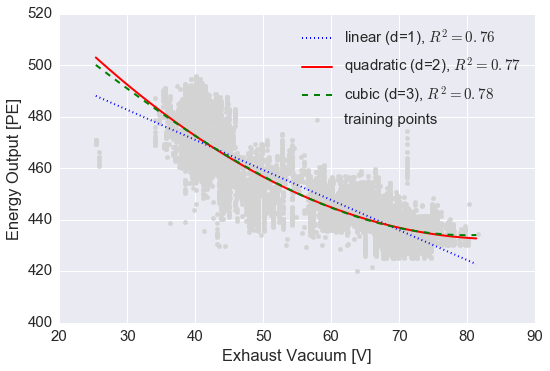

In [84]:
X = df[['V']].values
y = df['PE'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

As we can see in the resulting plot, the cubic fit captures the relationship between
the Energy Output [PE] and V better than the linear and quadratic fit. However, we
should be aware that adding more and more polynomial features increases the
complexity of a model and therefore increases the chance of overfitting. Thus, in
practice, it is always recommended that you evaluate the performance of the model
on a separate test dataset to estimate the generalization performance.

In addition, polynomial features are not always the best choice for modeling nonlinear
relationships. For example, just by looking at the PE-V scatterplot, we could
propose that a log transformation of the V feature variable and the square root of
PE may project the data onto a linear feature space suitable for a linear regression
fit. Let's test this hypothesis by executing the following code:

Transforming the dataset:

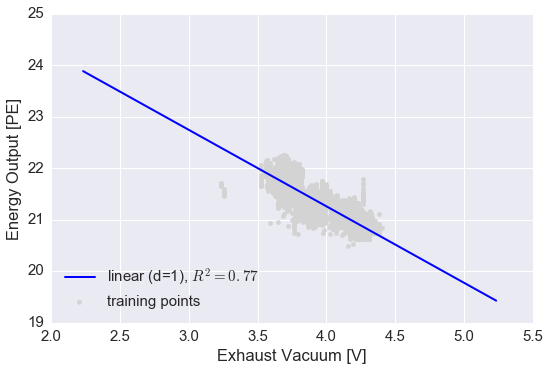

In [88]:
X = df[['V']].values
y = df['PE'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

After transforming the explanatory onto the log space and taking the square root
of the target variables, we were able to capture the relationship between the two
variables with a linear regression line that seems to fit the data better ( R^2 = 0.69 )
than any of the polynomial feature transformations previously.

## Dealing with nonlinear relationships using random forests

In this section, we are going to take a look at random forest regression, which is
conceptually different from the previous regression models in this chapter. A random
forest, which is an ensemble of multiple decision trees, can be understood as the sum
of piecewise linear functions in contrast to the global linear and polynomial regression
models that we discussed previously. In other words, via the decision tree algorithm,
we are subdividing the input space into smaller regions that become more manageable.

## Decision tree regression

An advantage of the decision tree algorithm is that it does not require any
transformation of the features if we are dealing with nonlinear data. When we used decision trees for classification, we defined
entropy as a measure of impurity to determine which feature split maximizes the
Information Gain (IG).  

In the context of decision tree regression, the MSE is often also referred to as
within-node variance, which is why the splitting criterion is also better known
as variance reduction. To see what the line fit of a decision tree looks like, let's use
the DecisionTreeRegressor implemented in scikit-learn to model the nonlinear
relationship between the PE and V variables:


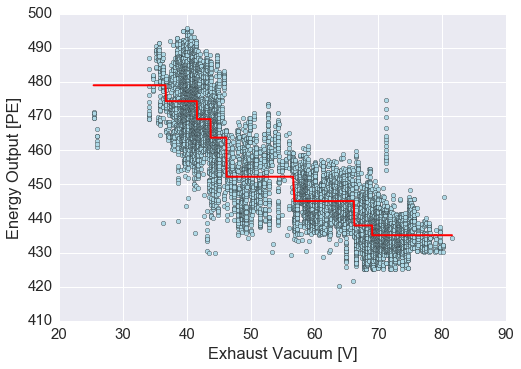

In [90]:
from sklearn.tree import DecisionTreeRegressor

X = df[['V']].values
y = df['PE'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

As we can see from the resulting plot, the decision tree captures the general
trend in the data. However, a limitation of this model is that it does not capture
the continuity and differentiability of the desired prediction. In addition, we
need to be careful about choosing an appropriate value for the depth of the tree
to not overfit or underfit the data; here, a depth of 3 seems to be a good choice.

## Random forest regression

The random forest algorithm is an ensemble technique that combines
multiple decision trees. A random forest usually has a better generalization
performance than an individual decision tree due to randomness that helps to
decrease the model variance. Other advantages of random forests are that they are
less sensitive to outliers in the dataset and don't require much parameter tuning.
The only parameter in random forests that we typically need to experiment with
is the number of trees in the ensemble. The basic random forests algorithm for
regression is almost identical to the random forest algorithm for classification , the only difference is that we use the MSE criterion to grow the individual decision
trees, and the predicted target variable is calculated as the average prediction over all
decision trees.

Now, let's use all the features in our dataset to fit a random forest
regression model on 60 percent of the samples and evaluate its performance
on the remaining 40 percent. The code is as follows:

In [91]:
X = df[features].values
y = df['PE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [92]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.551, test: 11.253
R^2 train: 0.995, test: 0.961


Unfortunately, we see that the random forest just slightly tends to overfit the training data.
However, it's still able to explain the relationship between the target and
explanatory variables relatively well ( R^2 = 0.961 on the test dataset).

Lastly, let's also take a look at the residuals of the prediction:

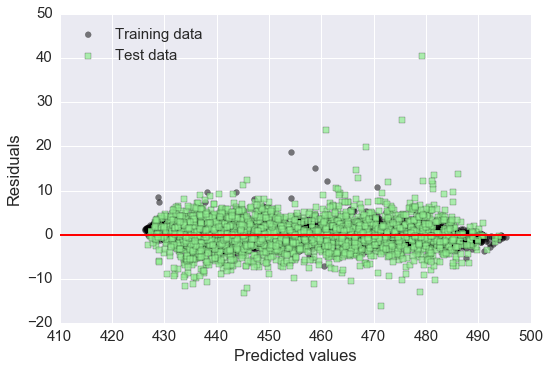

In [94]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=410, xmax=500, lw=2, color='red')
plt.xlim([410, 500])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

As it was already summarized by the R^2 coefficient, we can see that the model
fits the training data better than the test data, as indicated by the outliers in the y
axis direction. Also, the distribution of the residuals does not seem to be completely
random around the zero center point, indicating that the model is not able to
capture all the exploratory information. However, the residual plot indicates a
large improvement over the residual plot of the linear model that we plotted
earlier in this chapter.

### Summary
At the beginning , you learned about using simple linear regression
analysis to model the relationship between a single explanatory variable and a
continuous response variable. We then discussed a useful explanatory data analysis
technique to look at patterns and anomalies in data, which is an important first step
in predictive modeling tasks.

We built our first model by implementing linear regression using a gradient-based
optimization approach. We then saw how to utilize scikit-learn's linear models
for regression and also implement a robust regression technique (RANSAC) as an
approach for dealing with outliers. To assess the predictive performance of regression
models, we computed the mean sum of squared errors and the related R^2 metric.
Furthermore, we also discussed a useful graphical approach to diagnose the problems
of regression models: the residual plot.

After we discussed how regularization can be applied to regression models to reduce
the model complexity and avoid overfitting, we also introduced several approaches
to model nonlinear relationships, including polynomial feature transformation and
random forest regressors.

___

In [118]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split
from sklearn. cross_validation import cross_val_score

from sklearn.feature_selection import *
from sklearn import metrics

In [158]:
features=list(df.columns[:-1])
X = df[features]
y = df['PE']

# Linear Regression

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_predictions = regressor.predict(X_test)
print 'R-squared:', regressor.score(X_test, y_test)

R-squared: 0.929009302461


The r-squared score of 0.92 indicates that 92 percent of the variance in the test set is explained by the model. The performance might change if a different 75 percent of the data is partitioned to the training set. We can use cross-validation to produce a better estimate of the estimator's performance. Each cross-validation round trains and tests different partitions of the data to reduce variability.

In [116]:
scores = cross_val_score(regressor, X, y, cv=5)
print "Average of scores: ", scores.mean()
print "Cross validation scores: ", scores

Average of scores:  0.928461287012
Cross validation scores:  [ 0.92994188  0.91956987  0.93114222  0.92812498  0.93352748]


The cross_val_score helper function allows us to easily perform cross-validation
using the provided data and estimator. We specified a five-fold cross validation
using the cv keyword argument, that is, each instance will be randomly assigned
to one of the five partitions. Each partition will be used to train and test the model.
cross_val_score returns the value of the estimator's score method for each
round. The r-squared scores range from 0.91 to 0.93 The mean of the scores, 0.92, is a
better estimate of the estimator's predictive power than the r-squared score produced
from a single train / test split.

Let's inspect some of the model's predictions and plot the true quality scores against the predicted scores:

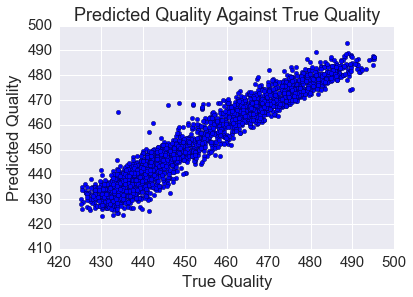

In [117]:
plt.scatter(y_test,y_predictions)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted Quality Against True Quality')
plt.show()

## Fitting models with gradient descent
Gradient descent is an optimization algorithm that can be used to estimate
the local minimum of a function.

We can use gradient descent to find the values of the model's parameters that
minimize the value of the cost function. Gradient descent iteratively updates the
values of the model's parameters by calculating the partial derivative of the cost
function at each step. The calculus required to compute the partial derivative of
the cost function is beyond the scope of this example, and is also not required to work
with scikit-learn. However, having an intuition for how gradient descent works
can help you use it effectively.

There are two varieties of gradient descent that are distinguished by the number of training instances that are used to update the model parameters in each training iteration.
1. Batch gradient descent, which is sometimes called only gradient descent, uses all of the training instances to update the model parameters in each iteration.
2. Stochastic Gradient Descent (SGD), in contrast, updates the parameters using only a single training instance in each iteration. The training instance is usually selected randomly. Stochastic gradient descent is often preferred to optimize cost functions when there are hundreds of thousands of training instances or more, as it will converge more quickly than batch gradient descent.

Batch gradient descent is a deterministic algorithm, and will produce the same parameter values given the same training set. As a stochastic algorithm, SGD can produce different parameter estimates each time it is run. SGD may not minimize the cost function as well as gradient descent because it uses only single training instances to update the weights.


# SGDRegressor

Here we use stochastic gradient descent to estimate the parameters of a model with
scikit-learn. SGDRegressor is an implementation of SGD that can be used even for
regression problems with hundreds of thousands or more features. It can be used
to optimize different cost functions to fit different linear models; by default, it will
optimize the residual sum of squares. 

In [119]:
# Scaling the features using StandardScaler:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it co

In [120]:
regressor = SGDRegressor(loss='squared_loss')
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print 'Cross validation r-squared scores:', scores
print 'Average cross validation r-squared score:', np.mean(scores)
regressor.fit_transform(X_train, y_train)
print 'Test set r-squared score', regressor.score(X_test, y_test)

Cross validation r-squared scores: [ 0.93266585  0.92048049  0.93033465  0.92782959  0.93074107]
Average cross validation r-squared score: 0.928410329472
Test set r-squared score 0.928377072949


C:\Miniconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


### Summary:
We assessed the fitness of models using the residual sum of squares cost function and discussed two methods to learn the values of a model's parameters that minimize the cost function. 

First, we solved the values of the model's parameters analytically. We then discussed gradient descent, a method that can efficiently estimate the optimal values of the model's parameters even when the model has a large number of features.

The features in these examples were simple measurements of their explanatory variables; it was easy to use them in our models. However there maybe some models which would require features for different types of explanatory variables, including categorical
variables, text, and images.


# Selecting the best features

In [159]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=33)

Sometimes there are a lot of features in the dataset, so before learning, we should try to see which features are more relevant for our learning task, i.e. which of them are better prize predictors. We will use the SelectKBest method from the feature_selection package, and plot the results.

In [160]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


[(True, 'AT'), (False, 'V'), (False, 'AP'), (False, 'RH')]


"\n# For more than 1 features\n\nfor i in range(5):\n    axes[i].set_aspect('equal')\n    axes[i].set_title('Feature ' + str(i))\n    axes[i].set_xlabel('Feature')\n    axes[i].set_ylabel('Energy Output')\n    axes[i].set_xlim(x_min, x_max)\n    axes[i].set_ylim(y_min, y_max)\n    plt.sca(axes[i])\n    plt.scatter(X_new[:,i],y_train)\n"

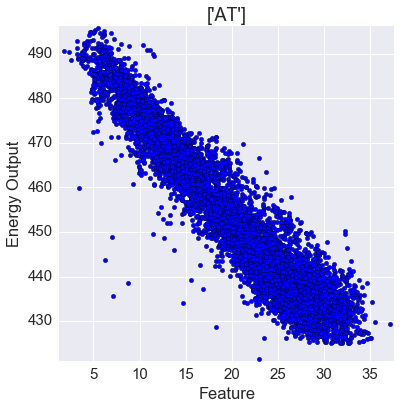

In [157]:
from sklearn.feature_selection import *

fs=SelectKBest(score_func=f_regression,k=1)
X_new=fs.fit_transform(X_train,y_train)
print zip(fs.get_support(),features)

x_min, x_max = X_new[:,0].min() - .5, X_new[:, 0].max() + .5
y_min, y_max = y_train.min() - .5, y_train.max() + .5

fig=plt.figure()
#fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Two subplots, unpack the axes array immediately
#fig, axes = plt.subplots(1,1)

fig.set_size_inches(6,6)

str = '{}'.format(features[:1])
plt.title(str)

plt.xlabel('Feature')
plt.ylabel('Energy Output')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.scatter(X_new[:],y_train)

"""
# For more than 1 features

for i in range(5):
    axes[i].set_aspect('equal')
    axes[i].set_title('Feature ' + str(i))
    axes[i].set_xlabel('Feature')
    axes[i].set_ylabel('Energy Output')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)
    plt.sca(axes[i])
    plt.scatter(X_new[:,i],y_train)
"""

In regression tasks, is very important to normalize data (to avoid that large-valued features weight too much in the final result)

In [161]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)

X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

print np.max(X_train), np.min(X_train), np.mean(X_train), np.max(y_train), np.min(y_train), np.mean(y_train)

3.37817667823 -3.42178257533 -1.42979892759e-15 2.44427247305 -1.9197011267 6.15882917562e-16


C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Miniconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it co

# A Linear Model

Let's start with a lineal model, SGDRegressor, that tries to find the hyperplane that minimizes a certain loss function (typically, the sum of squared distances from each instance to the hyperplane). It uses Stochastic Gradient Descent to find the minimum. 

Regression poses an additional problem: how should we evaluate our results? Accuracy is not a good idea, since
we are predicting real values, it is almost impossible for us to predict exactly the final value. There are several measures that can be used (you can look at the list of functions under sklearn.metrics module). The most common is the R2 score, or coefficient of determination that measures the proportion of the outcomes variation explained by the model, and is the default score function for regression methods in scikit-learn. This score reaches its maximum value of 1 when the model perfectly predicts all the test target values. 

In [162]:
from sklearn.cross_validation import *
def train_and_evaluate(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
    print "Coefficient of determination on training set:",clf.score(X_train, y_train)
    
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print "Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores)

In [163]:
from sklearn import linear_model
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None,  random_state=42)
train_and_evaluate(clf_sgd,X_train,y_train)
print clf_sgd.coef_

Coefficient of determination on training set: 0.92731596564
Average coefficient of determination using 5-fold crossvalidation: 0.926989459674
[-0.85747085 -0.1815999   0.02151552 -0.12691899]


You probably noted the penalty=None parameter when we called the method. The penalization parameter for linear regression methods is introduced to avoid overfitting. It does this by penalizing those hyperplanes having some of their coefficients too large, seeking hyperplanes where each feature contributes more or less the same to the predicted value. This parameter is generally the L2 norm (the squared sums of the coefficients) or the L1 norm (that is the sum of the absolute value of the coefficients). Let's see how our model works if we introduce an L2 or L1 penalty.

In [164]:
clf_sgd1 = linear_model.SGDRegressor(loss='squared_loss', penalty='l2',  random_state=42)
train_and_evaluate(clf_sgd1,X_train,y_train)

Coefficient of determination on training set: 0.927314408572
Average coefficient of determination using 5-fold crossvalidation: 0.926986596228


In [165]:
clf_sgd2 = linear_model.SGDRegressor(loss='squared_loss', penalty='l1',  random_state=42)
train_and_evaluate(clf_sgd2,X_train,y_train)

Coefficient of determination on training set: 0.927313926801
Average coefficient of determination using 5-fold crossvalidation: 0.926987951428


# Support Vector Machines for regression
The regression version of SVM can be used instead to find the hyperplane (note how easy is to change the classification method in scikit-learn!). We will try a linear kernel, a polynomial kernel, and finally, a rbf kernel. For more information on kernels, see http://scikit-learn.org/stable/modules/svm.html#svm-kernels

In [166]:
from sklearn import svm
clf_svr= svm.SVR(kernel='linear')
train_and_evaluate(clf_svr,X_train,y_train)

Coefficient of determination on training set: 0.927111256862
Average coefficient of determination using 5-fold crossvalidation: 0.926860561794


In [167]:
clf_svr_poly= svm.SVR(kernel='poly')
train_and_evaluate(clf_svr_poly,X_train,y_train)

Coefficient of determination on training set: 0.786647973553
Average coefficient of determination using 5-fold crossvalidation: 0.784801377463


In [168]:
clf_svr_rbf= svm.SVR(kernel='rbf')
train_and_evaluate(clf_svr_rbf,X_train,y_train)

Coefficient of determination on training set: 0.944381068672
Average coefficient of determination using 5-fold crossvalidation: 0.942495232494


In [169]:
clf_svr_poly2= svm.SVR(kernel='poly',degree=2)
train_and_evaluate(clf_svr_poly2,X_train,y_train)

Coefficient of determination on training set: 0.191097824819
Average coefficient of determination using 5-fold crossvalidation: 0.186392719822


# Random Forests for Regression
Finally, let's try again Random Forests, in their Extra Trees, and Regression version

In [170]:
from sklearn import ensemble
clf_et=ensemble.ExtraTreesRegressor(n_estimators=10,random_state=42)
train_and_evaluate(clf_et,X_train,y_train)

Coefficient of determination on training set: 0.999999999826
Average coefficient of determination using 5-fold crossvalidation: 0.952735020371


An interesting side effect of random forest classification, is that you can measure how 'important' each feature is when predicting the final result

In [172]:
print np.sort(zip(clf_et.feature_importances_,features),axis=0)

[['0.0243751989395' 'AP']
 ['0.0263667680704' 'AT']
 ['0.273530281266' 'RH']
 ['0.675727751724' 'V']]


Finally, evaluate our classifiers on the testing set

In [180]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True,
                        show_classification_report=True,
                        show_confusion_matrix=True,
                        show_r2_score=False):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
    if show_r2_score:
        print "Coefficient of determination:{0:.3f}".format(metrics.r2_score(y,y_pred)),"\n"

        
measure_performance(X_test,y_test,clf_et,
                    show_accuracy=False,
                    show_classification_report=False,
                    show_confusion_matrix=False,
                    show_r2_score=True)

Coefficient of determination:0.963 



___